# AFNI Preprocessing & Group Analysis


**Author**: Monika Doerig

### Citation:

#### Tools included in this workflow
__AFNI__
- Cox RW (1996). AFNI: software for analysis and visualization of functional magnetic resonance neuroimages. Comput Biomed Res 29(3):162-173. [doi:10.1006/cbmr.1996.0014](https://pubmed.ncbi.nlm.nih.gov/8812068/)

- RW Cox, JS Hyde (1997). Software tools for analysis and visualization of FMRI Data. NMR in Biomedicine, 10: 171-178., [https://pubmed.ncbi.nlm.nih.gov/9430344/](https://pubmed.ncbi.nlm.nih.gov/9430344/)

#### Workflows this work is based on
- [AFNI Preprocessing](https://neurodesk.org/example-notebooks/functional_imaging/AFNI_preprocessing_only.html)
- [AFNI Preprocessing and GLM](https://neurodesk.org/example-notebooks/functional_imaging/AFNI_preprocessing_plus_glm.html)


#### Educational resources
__Andy's Brain Book__:

- This AFNI example is based on the [AFNI Tutorial: Statistics and Modeling](https://andysbrainbook.readthedocs.io/en/latest/AFNI/AFNI_Short_Course/AFNI_05_1stLevelAnalysis.html)  from Andy’s Brain Book (Jahn, 2022. [doi:10.5281/zenodo.5879293](https://zenodo.org/records/5879294))

#### Dataset
__Data from OpenNeuro:__ Flanker Dataset
- Kelly AMC and Uddin LQ and Biswal BB and Castellanos FX and Milham MP (2018). Flanker task (event-related). [OpenNeuro Dataset ds000102](https://openneuro.org/datasets/ds000102/versions/00001/). [Dataset] doi: null
- Kelly AM, Uddin LQ, Biswal BB, Castellanos FX, Milham MP. Competition between functional brain networks mediates behavioral variability. Neuroimage. 2008 Jan 1;39(1):527-37. doi: [10.1016/j.neuroimage.2007.08.008](https://doi.org/10.1016/j.neuroimage.2007.08.008). Epub 2007 Aug 23. PMID: 17919929.
- Mennes, M., Kelly, C., Zuo, X.N., Di Martino, A., Biswal, B.B., Castellanos, F.X., Milham, M.P. (2010). Inter-individual differences in resting-state functional connectivity predict task-induced BOLD activity. Neuroimage, 50(4):1690-701. doi: [10.1016/j.neuroimage.2010.01.002](https://doi.org/10.1016/j.neuroimage.2010.01.002). Epub 2010 Jan 15. Erratum in: Neuroimage. 2011 Mar 1;55(1):434
- Mennes, M., Zuo, X.N., Kelly, C., Di Martino, A., Zang, Y.F., Biswal, B., Castellanos, F.X., Milham, M.P. (2011). Linking inter-individual differences in neural activation and behavior to intrinsic brain dynamics. Neuroimage, 54(4):2950-9. doi: [10.1016/j.neuroimage.2010.10.046](https://doi.org/10.1016/j.neuroimage.2010.10.046)ed in your example

In [1]:
# Output CPU information:
!cat /proc/cpuinfo | grep 'vendor' | uniq
!cat /proc/cpuinfo | grep 'model name' | uniq

vendor_id	: GenuineIntel
model name	: Intel(R) Xeon(R) Gold 6126 CPU @ 2.60GHz


### Load packages

In [2]:
import module
await module.load('afni/21.2.00')
await module.list()

['afni/21.2.00']

### Import Python Modules

In [3]:
%%capture
! pip install nibabel numpy nilearn scipy

In [4]:
import os
from glob import glob
import subprocess
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import image, plotting
from ipyniivue import NiiVue
from IPython.display import display, Markdown, Image
from scipy.stats import ttest_1samp
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.notebook import tqdm 

## 1. Download Data

In [5]:
# 9 subjects from the Flanker Dataset
PATTERN = "sub-0*"
!datalad install https://github.com/OpenNeuroDatasets/ds000102.git
!cd ds000102 && datalad get $PATTERN

Cloning:   0%|                             | 0.00/2.00 [00:00<?, ? candidates/s]
Enumerating: 0.00 Objects [00:00, ? Objects/s]
                                              
Counting:   0%|                               | 0.00/27.0 [00:00<?, ? Objects/s]
                                                                                
Compressing:   0%|                            | 0.00/23.0 [00:00<?, ? Objects/s]
                                                                                
Receiving:   0%|                             | 0.00/2.15k [00:00<?, ? Objects/s]
                                                                                
Resolving:   0%|                                | 0.00/537 [00:00<?, ? Deltas/s]
[INFO   ] scanning for unlocked files (this may take some time)                 
[INFO   ] Remote origin not usable by git-annex; setting annex-ignore 
[INFO   ] access to 1 dataset sibling s3-PRIVATE not auto-enabled, enable with:
| 		datalad siblings -d "/

The data is structured in BIDS format:

In [6]:
!tree -L 4 ds000102

ds000102
├── CHANGES
├── README
├── T1w.json
├── dataset_description.json
├── derivatives
│   └── mriqc
│       ├── aMRIQC.csv -> ../../.git/annex/objects/Q4/jv/MD5E-s14180--3addf0456b803b7c5ec5147481ecdd62.csv/MD5E-s14180--3addf0456b803b7c5ec5147481ecdd62.csv
│       ├── anatomical_group.pdf -> ../../.git/annex/objects/6m/q9/MD5E-s98927--d11151f65ae061833e7fd4373adfec3f.pdf/MD5E-s98927--d11151f65ae061833e7fd4373adfec3f.pdf
│       ├── anatomical_sub-01.pdf -> ../../.git/annex/objects/K3/7x/MD5E-s2747349--5d40f2a54fb4194ac4a79f0295ff51c0.pdf/MD5E-s2747349--5d40f2a54fb4194ac4a79f0295ff51c0.pdf
│       ├── anatomical_sub-02.pdf -> ../../.git/annex/objects/Kx/Kv/MD5E-s2803965--56f6b768362bd9b7f0ef501b8cb6dde6.pdf/MD5E-s2803965--56f6b768362bd9b7f0ef501b8cb6dde6.pdf
│       ├── anatomical_sub-03.pdf -> ../../.git/annex/objects/kx/g5/MD5E-s2809843--e90d7a4859ed4be986b55e23f93ca89d.pdf/MD5E-s2809843--e90d7a4859ed4be986b55e23f93ca89d.pdf
│       ├── anatomical_sub-04.pdf -> ../../.git/annex/ob

### Creating Timing Files

Condition-specific timing files are generated using the same approach described in the [*Preprocessing and GLM*](https://neurodesk.org/example-notebooks/functional_imaging/AFNI_preprocessing_plus_glm.html) notebook. In brief:

- Onset times and durations are extracted from each subject’s `events.tsv` file.  
- Trials are categorized into **congruent** and **incongruent** conditions.  
- The `make_Timings.sh` script (from Andy’s [AFNI_Scripts repository](https://github.com/andrewjahn/AFNI_Scripts)) is used to convert this event information into AFNI-compatible `.1D` timing files.  
- For each subject, two timing files are created (one per condition), spanning both runs, and saved in the subject’s `func/` directory.  

These `.1D` timing files will then be used in the first-level GLM to model condition-specific brain responses.

In [7]:
!wget -O ds000102/make_Timings.sh https://raw.githubusercontent.com/andrewjahn/AFNI_Scripts/master/make_Timings.sh

--2025-07-10 05:02:02--  https://raw.githubusercontent.com/andrewjahn/AFNI_Scripts/master/make_Timings.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 953 [text/plain]
Saving to: ‘ds000102/make_Timings.sh’

ds000102/make_Timin 100%[===================>]     953  --.-KB/s    in 0s      

2025-07-10 05:02:02 (36.9 MB/s) - ‘ds000102/make_Timings.sh’ saved [953/953]



#### Running the Timing File Script
After placing the `make_Timings.sh` script into the `ds000102/` directory, we can execute it from within the notebook:

In [8]:
!cd ds000102 && chmod +x make_Timings.sh && bash make_Timings.sh

/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \
/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \
/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \
/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \
/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \
/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you miss

<div style="background-color: #f0f8ff; padding: 10px; border-radius: 5px;">
    <div style="background-color: #add8e6; padding: 5px; border-radius: 5px; font-weight: bold;">
        <span style="font-size: 15px; color: #add8e6; background-color: white; border-radius: 50%; width: 20px; height: 20px; display: inline-block; text-align: center; line-height: 20px;">
            !
        </span> <span style="color: white;">Note:</span>
    </div>
    <p style="margin: 10px 0;">
        You may see a SyntaxWarning from AFNI’s internal Python scripts when running this command - this can be safely ignored and does not affect the output.
    </p>
</div>

Check the output:

In [9]:
!cat ds000102/sub-01/func/incongruent.1D

0 10 40 76 102 150 164 174 208 220 232 260 
0 54 64 76 88 130 144 154 196 246 274 


## 2. Running Preprocessing and First-Level Analysis for All Subjects

All of the preprocessing and regression steps for subject `sub-08` were introduced and explained in the example notebooks [Preprocessing with AFNI](https://neurodesk.org/example-notebooks/functional_imaging/AFNI_preprocessing_only.html) and [AFNI Preprocessing and GLM](https://neurodesk.org/example-notebooks/functional_imaging/AFNI_preprocessing_plus_glm.html), both of which are highly inspired by [Andy's Brain Book’s tutorial](https://andysbrainbook.readthedocs.io/en/latest/AFNI/AFNI_Short_Course/AFNI_04_Preprocessing.html).  
These notebooks demonstrate how to use `afni_proc.py` to generate an automated pipeline and interpret each preprocessing and regression block.

<div style="background-color: #e8f5e9; padding: 12px; border-left: 6px solid #66bb6a; margin: 10px 0; font-size: 14px;">
<b>Preprocessing and GLM Workflow:</b><br><br>

➡️ <code>setup</code> ➡️ <code>tcat</code> ➡️ <code>align</code> ➡️ <code>volreg</code> ➡️ <code>tlrc</code> ➡️ <code>blur</code> ➡️ <code>mask</code> ➡️ <code>scale</code> ➡️ <code>regress</code> 🧠<br><br>


✅ <b>Outputs:</b> fitted time series, beta weights, and statistical maps from the GLM.
</div>


To replicate the preprocessing and GLM steps used for `sub-08` across multiple participants, we loop over all 9 subjects (sub-01 to sub-09) and generate an individualized AFNI pipeline for each one using `afni_proc.py`. This automated approach performs several key operations:

- Loads each subject's anatomical image and both functional runs.

- Specifies the full processing pipeline: alignment, linear registration to MNI space, motion correction, blurring, masking, scaling, and regression modeling.

- Models two stimulus conditions (congruent and incongruent) using a gamma basis function.

- Specifies two general linear tests (GLTs): incongruent - congruent and congruent - incongruent.

- Censors time points with excessive motion (> 0.3 mm), disables motion derivatives, and estimates spatial smoothness for later use in group analysis.

- Runs `3dREMLfit` for improved model estimation and produces a Pythonic HTML review report for each subject.

To improve alignment robustness, the script is post-edited to insert the `-init_xform AUTO_CENTER` option into the `@auto_tlrc` command as this works better on this dataset.

Processing is executed in parallel using a process pool, with up to 3 subjects processed simultaneously. Each subject's script is saved and executed in a controlled logging environment, which captures terminal output into a log file for transparency and troubleshooting.

This block ensures consistent preprocessing and first-level GLM estimation across all subjects in the dataset.


In [10]:
# Create directory for output
os.makedirs("afni_pro_glm", exist_ok=True)

# Main subject processing function
def process_subject(subj_id):
    subj = f"sub-{subj_id:02d}"
    anat = f"./ds000102/{subj}/anat/{subj}_T1w.nii.gz"
    func1 = f"./ds000102/{subj}/func/{subj}_task-flanker_run-1_bold.nii.gz"
    func2 = f"./ds000102/{subj}/func/{subj}_task-flanker_run-2_bold.nii.gz"
    stim1D_c = f"./ds000102/{subj}/func/congruent.1D"
    stim1D_i = f"./ds000102/{subj}/func/incongruent.1D"
    out_dir = f"./afni_pro_glm/{subj}.results"
    script_name = f"./afni_pro_glm/proc.{subj}.tcsh"
    log_file = f"./afni_pro_glm/output.{subj}.log"

    # Skip subject if already processed
    if os.path.exists(out_dir):
        return f"{subj} skipped (already processed)"

    cmd = [
        "afni_proc.py",
        "-subj_id", subj,
        "-script", script_name,
        "-scr_overwrite",
        "-out_dir", out_dir,
        "-blocks", "align", "tlrc", "volreg", "blur", "mask", "scale", "regress",
        "-copy_anat", anat,
        "-dsets", func1, func2,
        "-tcat_remove_first_trs", "0",
        "-align_opts_aea", "-giant_move",
        "-tlrc_base", "MNI_avg152T1+tlrc",
        "-volreg_align_to", "MIN_OUTLIER",
        "-volreg_align_e2a",
        "-volreg_tlrc_warp",
        "-blur_size", "4.0",
        "-regress_stim_times", stim1D_c, stim1D_i,
        "-regress_stim_labels", "congruent", "incongruent",
        "-regress_stim_types", "times", "times",
        "-regress_basis", "GAM",
        "-regress_opts_3dD",
        "-gltsym", "SYM: +incongruent -congruent", "-glt_label", "1", "incongruent-congruent",
        "-gltsym", "SYM: +congruent -incongruent", "-glt_label", "2", "congruent-incongruent",
        "-jobs", "8",                        #  speedup with multithreading
        "-GOFORIT", "0",                     #  safe default
        "-regress_no_motion_deriv",          #  disables motion derivatives (simpler model)
        "-regress_censor_motion", "0.3",     #  standard threshold
        "-regress_motion_per_run",           #  run-wise motion parameters
        "-regress_est_blur_epits",
        "-regress_est_blur_errts",
        "-regress_make_ideal_sum", "sum_ideal.1D",
        "-regress_reml_exec",                
        "-regress_run_clustsim", "no",       #  skip, since you'll do group-level stats separately
        "-html_review_style", "pythonic"
    ]

    try:
        # Step 1: Create the AFNI processing script
        subprocess.run(cmd, check=True)

        # Step 2: Insert -init_xform AUTO_CENTER into the @auto_tlrc command
        with open(script_name, 'r') as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            if line.strip().startswith("@auto_tlrc") and "AUTO_CENTER" not in line:
                lines[i] = line.strip() + " -init_xform AUTO_CENTER\n"
        with open(script_name, 'w') as f:
            f.writelines(lines)

        # Step 3: Run the AFNI tcsh script, logging output
        with open(log_file, "w") as logfile:
            proc = subprocess.Popen(
                ["tcsh", "-xef", script_name],
                stdout=subprocess.PIPE,
                stderr=subprocess.STDOUT,
                text=True
            )
            for line in proc.stdout:
                print(line, end="")     # Stream to console
                logfile.write(line)     # Log to file
            proc.wait()

        return f"{subj} {'done' if proc.returncode == 0 else 'failed'}"
        
    except subprocess.CalledProcessError as e:
        return f"{subj} failed: afni_proc.py error"
    except Exception as e:
        return f"{subj} failed: unexpected error\n{e}"

# ──────────────────────────────────────────────────────────────────────────────
# Main loop to process multiple subjects in parallel
if __name__ == "__main__":
    subject_ids = list(range(1, 10))  # sub-01 to sub-09
    results = []

    with ProcessPoolExecutor(max_workers=3) as executor:
        futures = {executor.submit(process_subject, sid): sid for sid in subject_ids}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Subjects processed"):
            results.append(future.result())

    print("\nSummary of results:")
    for r in results:
        print(r)

Subjects processed:   0%|          | 0/9 [00:00<?, ?it/s]

echo auto-generated by afni_proc.py, Thu Jul 10 05:02:34 2025
echo auto-generated by afni_proc.py, Thu Jul 10 05:02:34 2025
auto-generated by afni_proc.py, Thu Jul 10 05:02:34 2025
auto-generated by afni_proc.py, Thu Jul 10 05:02:34 2025
echo (version 7.16, May 19, 2021)
echo auto-generated by afni_proc.py, Thu Jul 10 05:02:34 2025
(version 7.16, May 19, 2021)
echo (version 7.16, May 19, 2021)
(version 7.16, May 19, 2021)
echo execution started: `date`
auto-generated by afni_proc.py, Thu Jul 10 05:02:34 2025
echo execution started: `date`
echo (version 7.16, May 19, 2021)
date
date
(version 7.16, May 19, 2021)
echo execution started: `date`
execution started: Thu Jul 10 05:02:35 UTC 2025
execution started: Thu Jul 10 05:02:35 UTC 2025
afni -ver
date
afni -ver
execution started: Thu Jul 10 05:02:35 UTC 2025
afni -ver
-- applying input view as +orig
-- will use min outlier volume as motion base
-- tcat: reps is now 146
++ updating polort to 2, from run len 292.0 s
-- volreg: using base d

/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \
/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \
/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \


Precompiled binary linux_openmp_64: Jul  8 2021 (Version AFNI_21.2.00 'Nerva')
afni_history -check_date 27 Jun 2019
Precompiled binary linux_openmp_64: Jul  8 2021 (Version AFNI_21.2.00 'Nerva')
Precompiled binary linux_openmp_64: Jul  8 2021 (Version AFNI_21.2.00 'Nerva')
afni_history -check_date 27 Jun 2019
afni_history -check_date 27 Jun 2019
-- is current: afni_history as new as: 27 Jun 2019
               most recent entry is:   30 Jun 2021
if ( 0 ) then
-- is current: afni_history as new as: 27 Jun 2019
if ( 0 > 0 ) then
               most recent entry is:   30 Jun 2021
set subj = sub-02
endif
if ( 0 ) then
if ( 0 > 0 ) then
set subj = sub-03
endif
set output_dir = ./afni_pro_glm/sub-03.results
set output_dir = ./afni_pro_glm/sub-02.results
if ( -d ./afni_pro_glm/sub-03.results ) then
if ( -d ./afni_pro_glm/sub-02.results ) then
set runs = ( `count -digits 2 1 2` )
set runs = ( `count -digits 2 1 2` )
count -digits 2 1 2
count -digits 2 1 2
-- is current: afni_history as new as:

/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \
/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \


-- applying input view as +orig
-- will use min outlier volume as motion base
-- tcat: reps is now 146
++ updating polort to 2, from run len 292.0 s
-- volreg: using base dset vr_base_min_outlier+orig
++ volreg: applying volreg/epi2anat/tlrc xforms to isotropic 3 mm tlrc voxels
-- applying anat warps to 1 dataset(s): sub-04_T1w
-- masking: group anat = 'MNI_avg152T1+tlrc', exists = 1
-- have 1 ROI dict entries ...
** failed to load module matplotlib.pyplot
** warning: -html_review_style pythonic: missing matplotlib library
-- using default: will not apply EPI Automask
   (see 'MASKING NOTE' from the -help for details)

--> script is file: ./afni_pro_glm/proc.sub-04.tcsh

    to execute via tcsh:
         tcsh -xef ./afni_pro_glm/proc.sub-04.tcsh |& tee ./afni_pro_glm/output.proc.sub-04.tcsh

    to execute via bash:
         tcsh -xef ./afni_pro_glm/proc.sub-04.tcsh 2>&1 | tee ./afni_pro_glm/output.proc.sub-04.tcsh

-- applying input view as +orig
-- will use min outlier volume as moti

/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \


-- applying input view as +orig
-- will use min outlier volume as motion base
-- tcat: reps is now 146
++ updating polort to 2, from run len 292.0 s
-- volreg: using base dset vr_base_min_outlier+orig
++ volreg: applying volreg/epi2anat/tlrc xforms to isotropic 3 mm tlrc voxels
-- applying anat warps to 1 dataset(s): sub-06_T1w
-- masking: group anat = 'MNI_avg152T1+tlrc', exists = 1
-- have 1 ROI dict entries ...
** failed to load module matplotlib.pyplot
** warning: -html_review_style pythonic: missing matplotlib library
-- using default: will not apply EPI Automask
   (see 'MASKING NOTE' from the -help for details)

--> script is file: ./afni_pro_glm/proc.sub-06.tcsh

    to execute via tcsh:
         tcsh -xef ./afni_pro_glm/proc.sub-06.tcsh |& tee ./afni_pro_glm/output.proc.sub-06.tcsh

    to execute via bash:
         tcsh -xef ./afni_pro_glm/proc.sub-06.tcsh 2>&1 | tee ./afni_pro_glm/output.proc.sub-06.tcsh

Precompiled binary linux_openmp_64: Jul  8 2021 (Version AFNI_21.2.00 

/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \


-- applying input view as +orig
-- will use min outlier volume as motion base
-- tcat: reps is now 146
++ updating polort to 2, from run len 292.0 s
-- volreg: using base dset vr_base_min_outlier+orig
++ volreg: applying volreg/epi2anat/tlrc xforms to isotropic 3 mm tlrc voxels
-- applying anat warps to 1 dataset(s): sub-07_T1w
-- masking: group anat = 'MNI_avg152T1+tlrc', exists = 1
-- have 1 ROI dict entries ...
** failed to load module matplotlib.pyplot
** warning: -html_review_style pythonic: missing matplotlib library
-- using default: will not apply EPI Automask
   (see 'MASKING NOTE' from the -help for details)

--> script is file: ./afni_pro_glm/proc.sub-07.tcsh

    to execute via tcsh:
         tcsh -xef ./afni_pro_glm/proc.sub-07.tcsh |& tee ./afni_pro_glm/output.proc.sub-07.tcsh

    to execute via bash:
         tcsh -xef ./afni_pro_glm/proc.sub-07.tcsh 2>&1 | tee ./afni_pro_glm/output.proc.sub-07.tcsh

Precompiled binary linux_openmp_64: Jul  8 2021 (Version AFNI_21.2.00 

/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \


-- applying input view as +orig
-- will use min outlier volume as motion base
-- tcat: reps is now 146
++ updating polort to 2, from run len 292.0 s
-- volreg: using base dset vr_base_min_outlier+orig
++ volreg: applying volreg/epi2anat/tlrc xforms to isotropic 3 mm tlrc voxels
-- applying anat warps to 1 dataset(s): sub-08_T1w
-- masking: group anat = 'MNI_avg152T1+tlrc', exists = 1
-- have 1 ROI dict entries ...
** failed to load module matplotlib.pyplot
** warning: -html_review_style pythonic: missing matplotlib library
-- using default: will not apply EPI Automask
   (see 'MASKING NOTE' from the -help for details)

--> script is file: ./afni_pro_glm/proc.sub-08.tcsh

    to execute via tcsh:
         tcsh -xef ./afni_pro_glm/proc.sub-08.tcsh |& tee ./afni_pro_glm/output.proc.sub-08.tcsh

    to execute via bash:
         tcsh -xef ./afni_pro_glm/proc.sub-08.tcsh 2>&1 | tee ./afni_pro_glm/output.proc.sub-08.tcsh

Precompiled binary linux_openmp_64: Jul  8 2021 (Version AFNI_21.2.00 

/opt/afni-latest/afnipy/lib_afni1D.py:1302: SyntaxWarning: 'str' object is not callable; perhaps you missed a comma?
  print('** uncensor from vec: nt = %d, but nocen len = %d' \


-- applying input view as +orig
-- will use min outlier volume as motion base
-- tcat: reps is now 146
++ updating polort to 2, from run len 292.0 s
-- volreg: using base dset vr_base_min_outlier+orig
++ volreg: applying volreg/epi2anat/tlrc xforms to isotropic 3 mm tlrc voxels
-- applying anat warps to 1 dataset(s): sub-09_T1w
-- masking: group anat = 'MNI_avg152T1+tlrc', exists = 1
-- have 1 ROI dict entries ...
** failed to load module matplotlib.pyplot
** warning: -html_review_style pythonic: missing matplotlib library
-- using default: will not apply EPI Automask
   (see 'MASKING NOTE' from the -help for details)

--> script is file: ./afni_pro_glm/proc.sub-09.tcsh

    to execute via tcsh:
         tcsh -xef ./afni_pro_glm/proc.sub-09.tcsh |& tee ./afni_pro_glm/output.proc.sub-09.tcsh

    to execute via bash:
         tcsh -xef ./afni_pro_glm/proc.sub-09.tcsh 2>&1 | tee ./afni_pro_glm/output.proc.sub-09.tcsh

Precompiled binary linux_openmp_64: Jul  8 2021 (Version AFNI_21.2.00 

## 3. Group - Analysis

After estimating the first-level general linear model (GLM) for each subject, we will perform a group-level analysis to assess whether the `Incongruent - Congruent` contrast showed a consistent effect across subjects.

#### Creating a Group Mask
First, we'll create a group-level mask by combining each subject’s individual mask using a logical union. This ensures that only voxels present in all subjects' data are included in the group analysis:

In [11]:
! 3dmask_tool -input afni_pro_glm/sub-*.results/mask_group+tlrc.HEAD -prefix ./afni_pro_glm/group_mask+tlrc -union

++ processing 9 input dataset(s), NN=2...
++ padding all datasets by 0 (for dilations)
++ frac 0 over 9 volumes gives min count 0
++ voxel limits: 0 clipped, 73409 survived, 198224 were zero
++ writing result group_mask...
++ Output dataset ./afni_pro_glm/group_mask+tlrc.BRIK


### 3.1 Group-Level Analysis with 3dttest++ 

AFNI’s `3dttest++` performs a voxelwise one-sample t-test across subjects. This tests whether the average contrast estimate (e.g., *Incongruent - Congruent*) is significantly different from zero at each voxel.oxelwise t-scoresariability.

#### Identifying Contrast Sub-Brick

Before running the group-level test, we must determine which sub-brick contains the desired contrast. We use `3dinfo` to inspect the subject-level `stats+tlrc` dataset and find the index of the contrast sub-brick corresponding to *incongruent minus congruent* (e.g., sub-brick **#7**, depending on how GLTs were defined in `afni_proc.py`):

In [12]:
! 3dinfo -verb ./afni_pro_glm/sub-08.results/stats.sub-08+tlrc.BRIK

++ 3dinfo: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]

Dataset File:    stats.sub-08+tlrc
Identifier Code: XYZ_cML-nkJKyuw9qa6J_U-j5Q  Creation Date: Thu Jul 10 05:40:04 2025
Template Space:  MNI
Dataset Type:    Func-Bucket (-fbuc)
Byte Order:      LSB_FIRST [this CPU native = LSB_FIRST]
Storage Mode:    BRIK
Storage Space:   14,124,916 (14 million) bytes
Geometry String: "MATRIX(-3,0,0,90,0,-3,0,126,0,0,3,-72):61,73,61"
Data Axes Tilt:  Plumb
Data Axes Orientation:
  first  (x) = Left-to-Right
  second (y) = Posterior-to-Anterior
  third  (z) = Inferior-to-Superior   [-orient LPI]
R-to-L extent:   -90.000 [R] -to-    90.000 [L] -step-     3.000 mm [ 61 voxels]
A-to-P extent:   -90.000 [A] -to-   126.000 [P] -step-     3.000 mm [ 73 voxels]
I-to-S extent:   -72.000 [I] -to-   108.000 [S] -step-     3.000 mm [ 61 voxels]
Number of values stored at each pixel = 13
  -- At sub-brick #0 'Full_Fstat' datum type is float:            0 to       55.6688
     statcode = fift;  statpar = 

This command lists all sub-bricks with their labels, allowing us to find the relevant contrast parameter estimate:
```javascript
-- At sub-brick #7 'incongruent-congruent_GLT#0_Coef' datum type is float:     -19.9548 to       21.7222
```

Sub-bricks labeled with "Coef" represent contrast (beta) estimates, while "Tstat" or "Fstat" indicate test statistics. For group analysis, we will extract the Coef sub-brick (here: index [7]).

We then automate the `3dttest++` execution with the following steps:

**- Set the base directo**ry containing all subjects' AFNI result folders.**
- Locate sub-brick `[**7]` for each subject (the contrast of interest).**
- Verify dat**aset existence to avoid processing missing subjects.
- Construct the `3dttest++` command with:
  - An output prefix for group results,
  - A group brain mask to constrain the analysis,
  - A label for the subject set (`Inc-Con`),
  - Subpaired with their corresponding contrast sub-brick pathssti**mates.
- Run **the command using `subprocess.run()` to capture and log output.

The resulting dataset (`Flanker_Inc-Con_ttest+tlrc`) contains:

- **Effect size map:** average contrast values across subjects
- **T-statistic map:** voxelwise t-values representing statistical significance


In [13]:
base_dir = os.path.abspath("./afni_pro_glm")

# Get all subject folders
subject_dirs = sorted(glob(os.path.join(base_dir, "sub-*.results")))

# Build paths to sub-brik 7 (e.g. Inc-Con contrast)
set_lines = []
for s in subject_dirs:
    sub_id = os.path.basename(s).replace('.results', '')
    stats_path = os.path.join(s, f"stats.{sub_id}+tlrc[7]")
    if os.path.exists(stats_path.replace('[7]', '.BRIK')) or os.path.exists(stats_path):  # extra check
        set_lines.append(f"{sub_id} {stats_path}")
    else:
        print(f"⚠️  Missing file for subject {sub_id}: {stats_path}")

# Build 3dttest++ command
cmd_list = [
    "3dttest++",
    "-prefix", os.path.join(base_dir, "group_results", "Flanker-Inc-Con_ttest"),
    "-mask", os.path.join(base_dir, "group_mask+tlrc"),
    "-setA", "Inc-Con"
]

# Add subject lines
for line in set_lines:
    cmd_list += line.split()

# Run the command
print("Running 3dttest++...")
print("\n")
print("Command:", " ".join(cmd_list))
result = subprocess.run(cmd_list, capture_output=True, text=True)

# Show output
print(result.stdout)
print(result.stderr)

Running 3dttest++...


Command: 3dttest++ -prefix /home/jovyan/Git_repositories/example-notebooks/books/functional_imaging/afni_pro_glm/group_results/Flanker-Inc-Con_ttest -mask /home/jovyan/Git_repositories/example-notebooks/books/functional_imaging/afni_pro_glm/group_mask+tlrc -setA Inc-Con sub-01 /home/jovyan/Git_repositories/example-notebooks/books/functional_imaging/afni_pro_glm/sub-01.results/stats.sub-01+tlrc[7] sub-02 /home/jovyan/Git_repositories/example-notebooks/books/functional_imaging/afni_pro_glm/sub-02.results/stats.sub-02+tlrc[7] sub-03 /home/jovyan/Git_repositories/example-notebooks/books/functional_imaging/afni_pro_glm/sub-03.results/stats.sub-03+tlrc[7] sub-04 /home/jovyan/Git_repositories/example-notebooks/books/functional_imaging/afni_pro_glm/sub-04.results/stats.sub-04+tlrc[7] sub-05 /home/jovyan/Git_repositories/example-notebooks/books/functional_imaging/afni_pro_glm/sub-05.results/stats.sub-05+tlrc[7] sub-06 /home/jovyan/Git_repositories/example-notebooks/books/

This code snippet automates running AFNI’s `3dttest++` for a group analysis of the *Incongruent - Congruent* contrast:

- **Set the base directory** where all subjects’ AFNI results are stored.
- **Find all subject result folders** matching the pattern `sub-*.results`.
- **Build a list of dataset paths** pointing to the 7th sub-brick `[7]` (the contrast of interest) in each subject’s stats dataset, verifying file existence and alerting if missing.
- **Construct the `3dttest++` command** with:
  - Output prefix for group results,
  - Group mask to restrict the test to voxels common across subjects,
  - Label for the group set (`Inc-Con`),
  - Subject IDs paired with their corresponding contrast sub-brick paths.
- **Run the command** as a subprocess, capturing and printing AFNI’s output and errors for review.



The resulting output (Flanker_Inc-Con_ttest+tlrc) contains:

- **Effect size map**: average contrast across subjects

- **T-statistic map**: voxelwise t-sores


### 3.2 Performing Group Analysis with 3dMEMA

To account for both the variability within subjects (parameter estimate differences) and the variability across subjects (contrast estimate precision), we will also perform a group-level analysis using AFNI’s `3dMEMA.`

Unlike a simple t-test, `3dMEMA` leverages each subject’s contrast estimate and corresponding t-statistic (or standard error), providing a more accurate mixed-effects model.

The steps we will take are:

- Build a set list containing each subject’s ID along with the paths to their contrast estimate (`_REML+tlrc[7]`) and t-statistic (`_REML+tlrc[8]`) sub-bricks.

- Verify that both files exist for each subject to avoid missing data errors.

- Construct the `3dMEMA` command with an output prefix, the group mask, and the full subject set list.

- Run the command as a subprocess, capturing output for review.

This process will produce a group-level statistical map that balances effect size and reliability, offering a robust inference about the **Incongruent - Congruent** contrast across subjects.

In [14]:
# Build set list: all subjects in one set block
set_list = ["-set", "IncCon"]
for s in subject_dirs:
    sub_id = os.path.basename(s).replace(".results", "")
    coef_path = os.path.join(s, f"stats.{sub_id}_REML+tlrc[7]")
    tstat_path = os.path.join(s, f"stats.{sub_id}_REML+tlrc[8]")

    # Sanity check (optional)
    if os.path.exists(coef_path.replace("[7]", ".HEAD")) and os.path.exists(tstat_path.replace("[8]", ".HEAD")):
        set_list += [sub_id, coef_path, tstat_path]
    else:
        print(f"⚠️ Missing for {sub_id}:\n  {coef_path}\n  {tstat_path}")

# Full 3dMEMA command
cmd_list = [
    "3dMEMA",
    "-prefix", os.path.join(base_dir, "group_results", "Flanker_Inc-Con_MEMA"),
    "-mask", os.path.join(base_dir, "group_mask+tlrc"),
] + set_list

# Print and run
print("Running 3dMEMA...\n")
print("Command:", " ".join(cmd_list), "\n")
result = subprocess.run(cmd_list, capture_output=True, text=True)

print(result.stdout)
print(result.stderr)

Running 3dMEMA...

Command: 3dMEMA -prefix /home/jovyan/Git_repositories/example-notebooks/books/functional_imaging/afni_pro_glm/group_results/Flanker_Inc-Con_MEMA -mask /home/jovyan/Git_repositories/example-notebooks/books/functional_imaging/afni_pro_glm/group_mask+tlrc -set IncCon sub-01 /home/jovyan/Git_repositories/example-notebooks/books/functional_imaging/afni_pro_glm/sub-01.results/stats.sub-01_REML+tlrc[7] /home/jovyan/Git_repositories/example-notebooks/books/functional_imaging/afni_pro_glm/sub-01.results/stats.sub-01_REML+tlrc[8] sub-02 /home/jovyan/Git_repositories/example-notebooks/books/functional_imaging/afni_pro_glm/sub-02.results/stats.sub-02_REML+tlrc[7] /home/jovyan/Git_repositories/example-notebooks/books/functional_imaging/afni_pro_glm/sub-02.results/stats.sub-02_REML+tlrc[8] sub-03 /home/jovyan/Git_repositories/example-notebooks/books/functional_imaging/afni_pro_glm/sub-03.results/stats.sub-03_REML+tlrc[7] /home/jovyan/Git_repositories/example-notebooks/books/functi

### 3.3 Visualizing Group-Level Results

Now that we have completed both group analyses — one with `3dttest++` and one with `3dMEMA` — let's visualize the resulting **voxelwise t-statistic maps**.

#### Steps:

1. **Convert AFNI datasets to NIfTI format** using `3dcopy`, to ensure compatibility with Python neuroimaging tools like `nilearn`.

2. **Extract the t-statistic sub-brick** (sub-brick index `[1]`) using `3dTcat`. This gives us:
   - `Inc-Con_Tstat` from the `3dttest++` result  
   - `IncCon_Tstat` from the `3dMEMA` result

3. **Load the statistical maps** into Python using `nilearn.image.load_img()`.

4. **Apply voxelwise thresholding**:
   - A **two-tailed threshold** of *T* > 3.3
   - A **minimum cluster size** of 40 contiguous voxels  

   This reduces noise and highlights clusters likely to reflect meaningful effects.

   > **Note on Multiple Comparison Correction:**  
   > Cluster-size correction using `3dClustSim` requires stable estimates of spatial smoothness, which generally requires at least 14 subjects.  
   > Since our analysis includes only 9 subjects, we do not apply `3dClustSim` or other parametric corrections.  
   > Instead, we apply an **uncorrected voxelwise threshold** (T > 3.3) with a **minimum cluster size** of 40 voxels.  
   > This approach is intended for **exploratory visualization only** and should not be used for formal statistical inference.

5. **Plot the thresholded maps** using `nilearn.plotting.plot_stat_map()` to qualitatively compare the spatial activation patterns between the two group-level methods.

---

This approach allows us to visually inspect and compare the **sensitivity** and **spatial extent** of effects revealed by the simple one-sample t-test (`3dttest++`) and the mixed-effects model (`3dMEMA`) for the *Incongruent - Congruent* contrast.

In [15]:
! 3dcopy ./afni_pro_glm/group_results/Flanker-Inc-Con_ttest+tlrc ./afni_pro_glm/group_results/Flanker-Inc-Con_ttest.nii.gz
! 3dcopy ./afni_pro_glm/group_results/Flanker_Inc-Con_MEMA+tlrc ./afni_pro_glm/group_results/Flanker_Inc-Con_MEMA.nii.gz

++ 3dcopy: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
++ 3dcopy: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]


In [16]:
! 3dinfo -verb ./afni_pro_glm/group_results/Flanker-Inc-Con_ttest.nii.gz

++ 3dinfo: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]

Dataset File:    /home/jovyan/Git_repositories/example-notebooks/books/functional_imaging/afni_pro_glm/group_results/Flanker-Inc-Con_ttest.nii.gz
Identifier Code: XYZ_XIzASD3GHkMp361OqibBeA  Creation Date: Thu Jul 10 05:50:26 2025
Template Space:  MNI
Dataset Type:    Anat Bucket (-abuc)
Byte Order:      LSB_FIRST {assumed} [this CPU native = LSB_FIRST]
Storage Mode:    NIFTI
Storage Space:   2,173,064 (2.2 million) bytes
Geometry String: "MATRIX(-3,0,0,90,0,-3,0,126,0,0,3,-72):61,73,61"
Data Axes Tilt:  Plumb
Data Axes Orientation:
  first  (x) = Left-to-Right
  second (y) = Posterior-to-Anterior
  third  (z) = Inferior-to-Superior   [-orient LPI]
R-to-L extent:   -90.000 [R] -to-    90.000 [L] -step-     3.000 mm [ 61 voxels]
A-to-P extent:   -90.000 [A] -to-   126.000 [P] -step-     3.000 mm [ 73 voxels]
I-to-S extent:   -72.000 [I] -to-   108.000 [S] -step-     3.000 mm [ 61 voxels]
Number of values stored at each pixel =

In [17]:
# Copy sub-brik 1 (T-statistic) for ttest++
!3dTcat -prefix ./afni_pro_glm/group_results/Flanker-Inc-Con_ttest_Tstat.nii.gz './afni_pro_glm/group_results/Flanker-Inc-Con_ttest+tlrc[1]'

# Copy sub-brik 1 (T-statistic) for MEMA
!3dTcat -prefix ./afni_pro_glm/group_results/Flanker_Inc-Con_MEMA_Tstat.nii.gz './afni_pro_glm/group_results/Flanker_Inc-Con_MEMA+tlrc[1]'

++ 3dTcat: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
++ elapsed time = 0.7 s
++ 3dTcat: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
++ elapsed time = 0.6 s


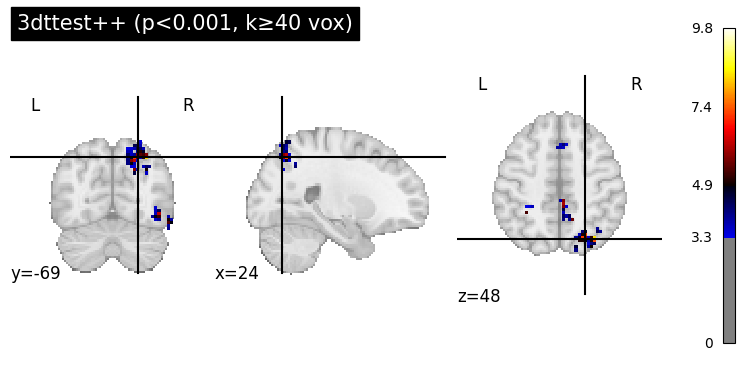

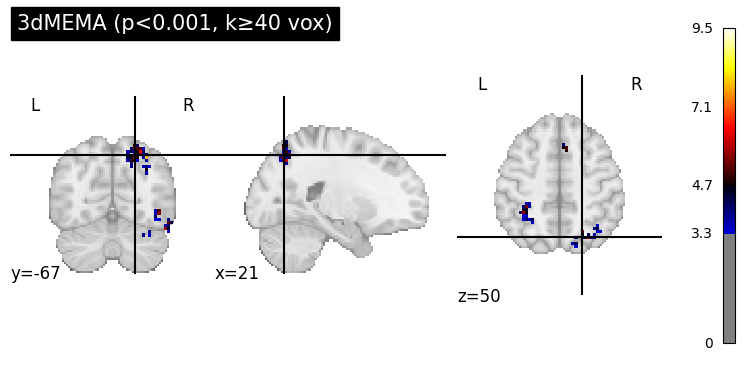

In [18]:
# Load T-stat map (3dttest++ and 3dMEMA results)
img_ttest = image.load_img("./afni_pro_glm/group_results/Flanker-Inc-Con_ttest_Tstat.nii.gz")
img_mema = image.load_img("./afni_pro_glm/group_results/Flanker_Inc-Con_MEMA_Tstat.nii.gz")


threshold = 3.3 

# Apply uncorrected voxel threshold (T > 3.3 ≈ p < 0.001)
# and minimum cluster size of 40 voxels
thresholded_img_ttest = image.threshold_img(
    img_ttest,
    threshold=threshold,
    cluster_threshold=40,
    two_sided=True,  
    copy_header=True
    
)

thresholded_img_mema = image.threshold_img(
    img_mema,
    threshold=threshold,
    cluster_threshold=40,
    two_sided=True,
    copy_header=True
    
)

# Plot result
plotting.plot_stat_map(
    thresholded_img_ttest,
    title="3dttest++ (p<0.001, k≥40 vox)",
    threshold=threshold,
    colorbar=True
)

plotting.plot_stat_map(
    thresholded_img_mema,
    title="3dMEMA (p<0.001, k≥40 vox)",
    threshold=threshold,
    colorbar=True
)
plotting.show()


## 4. ROI Analysis

### 4.1 ROI Analysis: Atlas-Based MidACC Mask

To investigate group-level effects within a specific anatomical region, we use an atlas-based Region of Interest (ROI) mask focusing on the **mid anterior cingulate cortex (midACC)**.


**1. Identify Available Atlases:**

We begin by confirming the available atlases using:
```bash
!whereami -show_atlas_code
```

This lists all atlases bundled with AFNI.

In [19]:
! whereami -show_atlas_code

++ Input coordinates orientation set by default rules to RAI

Atlas MNI_Glasser_HCP_v1.0,      360 regions
----------- Begin regions for MNI_Glasser_HCP_v1.0 atlas-----------
u:L_Primary_Visual_Cortex:1  
u:R_Primary_Visual_Cortex:1001
u:L_Medial_Superior_Temporal_Area:2  
u:R_Medial_Superior_Temporal_Area:1002
u:L_Sixth_Visual_Area:3  
u:R_Sixth_Visual_Area:1003
u:L_Second_Visual_Area:4  
u:R_Second_Visual_Area:1004
u:L_Third_Visual_Area:5  
u:R_Third_Visual_Area:1005
u:L_Fourth_Visual_Area:6  
u:R_Fourth_Visual_Area:1006
u:L_Eighth_Visual_Area:7  
u:R_Eighth_Visual_Area:1007
u:L_Primary_Motor_Cortex:8  
u:R_Primary_Motor_Cortex:1008
u:L_Primary_Sensory_Cortex:9  
u:R_Primary_Sensory_Cortex:1009
u:L_Frontal_Eye_Fields:10 
u:R_Frontal_Eye_Fields:1010
u:L_Premotor_Eye_Fields:11 
u:R_Premotor_Eye_Fields:1011
u:L_Area_55b:12 
u:R_Area_55b:1012
u:L_Area_V3A:13 
u:R_Area_V3A:1013
u:L_RetroSplenial_Complex:14 
u:R_RetroSplenial_Complex:1014
u:L_Parieto-Occipital_Sulcus_Area_2:15 
u:R_Parieto

**2. Generate ROI masks (midACC):**

Using the `DD_Desai_MPM` atlas, we create separate masks for the left and right midACC based on their region labels:

In [20]:
!whereami -mask_atlas_region DD_Desai_MPM::ctx_lh_G_and_S_cingul-Mid-Ant -prefix ./afni_pro_glm/group_results/midACC_lh_mask
!whereami -mask_atlas_region DD_Desai_MPM::ctx_rh_G_and_S_cingul-Mid-Ant -prefix ./afni_pro_glm/group_results/midACC_rh_mask

++ Input coordinates orientation set by default rules to RAI
Best match for ctx_lh_G_and_S_cingul-Mid-Ant:
   ctx_lh_G_and_S_cingul-Mid-Ant (code 7  )

++ Input coordinates orientation set by default rules to RAI
Best match for ctx_rh_G_and_S_cingul-Mid-Ant:
   ctx_rh_G_and_S_cingul-Mid-Ant (code 82 )



We then combine both hemispheres into a single bilateral ROI mask:

In [21]:
!3dmask_tool \
  -input ./afni_pro_glm/group_results/midACC_lh_mask+tlrc \
         ./afni_pro_glm/group_results/midACC_rh_mask+tlrc \
  -union \
  -prefix ./afni_pro_glm/group_results/midACC_mask

++ processing 2 input dataset(s), NN=2...
++ padding all datasets by 0 (for dilations)
++ frac 0 over 2 volumes gives min count 0
++ voxel limits: 0 clipped, 5546 survived, 4637855 were zero
++ writing result midACC_mask...
++ Output dataset ./afni_pro_glm/group_results/midACC_mask+tlrc.BRIK


To use the mask with Python tools like nilearn, we also convert it to NIfTI format:

In [22]:
! 3dAFNItoNIFTI -prefix ./afni_pro_glm/group_results/midACC_mask.nii.gz ./afni_pro_glm/group_results/midACC_mask+tlrc

++ 3dAFNItoNIFTI: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]


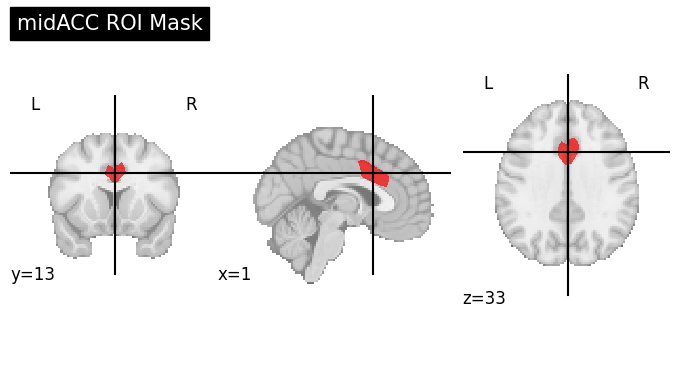

In [23]:
# Load AFNI mask
roi_img = image.load_img('./afni_pro_glm/group_results/midACC_mask.nii.gz')


# Plot ROI over mni background
plotting.plot_roi(roi_img,
                  title="midACC ROI Mask",
                  display_mode='ortho',
                  cmap='autumn', draw_cross=True)

**3. Resample the Mask to Match Functional Data:**

To ensure compatibility with the functional/statistical datasets, we resample the ROI mask to the same voxel resolution as the subject-level `stats+tlrc` files:

In [24]:
! 3dresample -master ./afni_pro_glm/sub-01.results/stats.sub-01+tlrc -input ./afni_pro_glm/group_results/midACC_mask+tlrc -prefix ./afni_pro_glm/group_results/midACC_rs+tlrc

**4. Extract Contrast Values from Each Subject:**

We extract the contrast estimate for each subject by:

1. Collecting the congruent and incongruent beta sub-bricks across all subjects:

In [25]:
subjects = [f"sub-{i:02d}" for i in range(1, 10)]


for subj in subjects:
    stats_path = f"./afni_pro_glm/{subj}.results/stats.{subj}+tlrc"
    
    if os.path.exists(f"{stats_path}.HEAD"):  # check AFNI header file
        subprocess.run([
            "3dbucket", "-aglueto", "./afni_pro_glm/group_results/Congruent_betas+tlrc.HEAD", f"{stats_path}[1]"
        ])
        subprocess.run([
            "3dbucket", "-aglueto", "./afni_pro_glm/group_results/Incongruent_betas+tlrc.HEAD", f"{stats_path}[4]"
        ])
    else:
        print(f"Skipping {subj}: stats file not found")

++ 3dbucket: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
++ 3dbucket: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
++ 3dbucket: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
*+ WARNING: Over-writing dataset ././afni_pro_glm/group_results/Congruent_betas+tlrc.HEAD
++ 3dbucket: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
*+ WARNING: Over-writing dataset ././afni_pro_glm/group_results/Incongruent_betas+tlrc.HEAD
++ 3dbucket: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
*+ WARNING: Over-writing dataset ././afni_pro_glm/group_results/Congruent_betas+tlrc.HEAD
++ 3dbucket: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
*+ WARNING: Over-writing dataset ././afni_pro_glm/group_results/Incongruent_betas+tlrc.HEAD
++ 3dbucket: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
*+ WARNING: Over-writing dataset ././afni_pro_glm/group_results/Congruent_betas+tlrc.HEAD
++ 3dbucket: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
*+ WARNING: Over-writing dataset ././afni_pro_glm/

This will produce 4D images:

- `Congruent_betas+tlrc` → all congruent betas across subjects

- `Incongruent_betas+tlrc` → all incongruent betas across subjects



2. Computing the subject-wise contrast *(Incongruent – Congruent)* using `3dcalc`:

In [26]:
# Create subject-wise contrast dataset (each sub-brick = Incongruent - Congruent)
! 3dcalc -a ./afni_pro_glm/group_results/Incongruent_betas+tlrc -b ./afni_pro_glm/group_results/Congruent_betas+tlrc -expr 'a-b' -prefix ./afni_pro_glm/group_results/incong_minus_cong+tlrc

++ 3dcalc: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset ././afni_pro_glm/group_results/incong_minus_cong+tlrc.BRIK


3. Extracting the mean contrast value within the ROI for each subject using `3dmaskave`:

In [27]:
# Extract average contrast value from ROI for each subject
! 3dmaskave -quiet -mask ./afni_pro_glm/group_results/midACC_rs+tlrc ./afni_pro_glm/group_results/incong_minus_cong+tlrc > ./afni_pro_glm/group_results/contrast_vals.txt

++ 3dmaskave: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
+++ 207 voxels survive the mask


**5. Statistical Testing:**
Finally, we load the contrast values and run a one-sample t-test to determine whether the average contrast across subjects significantly differs from zero:

In [28]:
# Load contrast values (one per subject)
contrast_vals = np.loadtxt("./afni_pro_glm/group_results/contrast_vals.txt")

# Run a one-sample t-test against 0
t_stat, p_val = ttest_1samp(contrast_vals, 0)

# Print results
print(f"Mean contrast: {np.mean(contrast_vals):.4f}")
print(f"t = {t_stat:.4f}, p = {p_val:.4f}")

Mean contrast: 0.1277
t = 2.5196, p = 0.0358


##### ✅ Interpretation

This provides a simple but interpretable ROI-based statistical test focused on the `Incongruent - Congruent` contrast in the midACC. This result indicates that:

- **On average**, the contrast *Incongruent - Congruent* is **positive** within the **mid anterior cingulate cortex (midACC)** ROI.  
- The difference is **statistically significant** at the **α = 0.05** level (*p* = 0.036).  
- This suggests that the **midACC shows greater activation** during **Incongruent** trials compared to **Congruent** trials across hte 9 subjects.

### 4.2 ROI Analysis Using a Spherical Mask

To complement the atlas-based ROI analysis, we can also define a **spherical ROI** centered on a coordinate of interest. This can be useful for hypothesis-driven analyses targeting specific anatomical or functional peaks.

**1. Define the sphere:**
   - A 5mm radius sphere is created around the coordinate *(0, 20, 44)* using AFNI's `3dUndump`.
   - The sphere is aligned to the grid of the functional data via the `-master` option.

   ```bash
   echo "0 20 44" | 3dUndump -orient LPI -srad 5 -master Incongruent_betas+tlrc -prefix ConflictROI+tlrc -xyz -
   ```


In [29]:
# This script creates a 5mm sphere around a coordinate
# Change the x,y,z, coordinates on the left side to select a different peak
# Radius size can be changed with the -srad option

! echo "0 20 44" | 3dUndump -orient LPI -srad 5 -master ./afni_pro_glm/group_results/Incongruent_betas+tlrc -prefix ./afni_pro_glm/group_results/ConflictROI+tlrc -xyz -

++ 3dUndump: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
++ Starting to fill via -xyz coordinates
++ Total number of voxels filled = 19
++ Wrote out dataset ././afni_pro_glm/group_results/ConflictROI+tlrc.BRIK


**2. Extract ROI contrast values:**


- The average `Incongruent - Congruent` contrast value will be computed for each subject using `3dmaskave`:

In [30]:
! 3dmaskave -quiet -mask ./afni_pro_glm/group_results/ConflictROI+tlrc ./afni_pro_glm/group_results/incong_minus_cong+tlrc > ./afni_pro_glm/group_results/contrast_vals_sphere.txt

++ 3dmaskave: AFNI version=AFNI_21.2.00 (Jul  8 2021) [64-bit]
+++ 19 voxels survive the mask


**3. Statistical test:**

- A one-sample t-test can be performed to determine whether the contrast values within the sphere significantly differ from zero.

In [31]:
# Load contrast values (one per subject)
contrast_vals_sphere = np.loadtxt("./afni_pro_glm/group_results/contrast_vals_sphere.txt")

# Run a one-sample t-test against 0
t_stat_sphere, p_val_sphere = ttest_1samp(contrast_vals_sphere, 0)

# Print results
print(f"Mean contrast: {np.mean(contrast_vals_sphere):.4f}")
print(f"t = {t_stat_sphere:.4f}, p = {p_val_sphere:.4f}")

Mean contrast: 0.2919
t = 3.3636, p = 0.0099


#### ✅ Interpretation of Sphere ROI Results

- The mean contrast value for *Incongruent-Congruent* in the spherical ROI is **0.2919**.
- The one-sample t-test shows a significant effect at the **α = 0.05** level:  
  *t*(8) = 3.36, *p* = 0.0099.
- This indicates that the ROI exhibits **significantly greater activation during Incongruent trials compared to Congruent trials** across subjects.